# Анализ пользовательского поведения в мобильном приложении

<div class="alert alert-block alert-info"> 
Планируется смена шрифтов в приложении для покупки продуктов питания, однако данное изменение может быть непривычным для пользователей и оказать негативное влияние. Необходимо разобраться, как ведут себя пользователи мобильного приложения после изменения шрифов: как и сколько пользователей доходят до покупки; cколько «застревает» на предыдущих шагах и на каких именно.
    
<br>Для выполнения задачи: 
1. Отберем необходимый период, в который пользователи совершали действия в приложении
2. Определимся с воронкой событий и проанализируем ее для всех пользователей (посмотрим на доли пользователей)
3. Проведем A/A-тест, чтобы выявить различия в контрольных группах и убедиться в правильности разбиения на группы
4. Проведем A/B-тест, чтобы выявить различие в долях пользователей в каждом событии по группам
    - эксперементальная группа с 1 контрольной группой
    - эксперементальная группа со 2 контрольной группой
    - эксперементальная группа с объединенной контрольной группой
5. Проанализирем результаты
</div>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import math as mth
from scipy import stats as st

### Шаг 1. Подготовка данных

In [3]:
data = pd.read_csv('logs_exp.csv', sep='\t') 
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.columns = ['event_name','device_id','event_timestamp','exp_id']

In [5]:
def first_step(df):
    # Проверим наличие пропусков
    missing_values = df.isnull().sum()
    print("Пропущенные значения:", missing_values.sum())

    # Проверим наличие дубликатов
    duplicate_values = df.duplicated().sum()
    print("Количество дубликатов:", duplicate_values)
    if duplicate_values != 0:
        print(f"Доля дубликатов {duplicate_values/df['device_id'].count():.1%}")
    
    print(data.info())
    print(df.head())

In [6]:
first_step(data)

Пропущенные значения: 0
Количество дубликатов: 413
Доля дубликатов 0.2%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id        244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
                event_name            device_id  event_timestamp  exp_id
0         MainScreenAppear  4575588528974610257       1564029816     246
1         MainScreenAppear  7416695313311560658       1564053102     246
2  PaymentScreenSuccessful  3518123091307005509       1564054127     248
3         CartScreenAppear  3518123091307005509       1564054127     248
4  PaymentScreenSuccessful  6217807653094995999       1564055322     248


В данных есть 413 дубликатов (0.2%), удалим их

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

Добавим столбец даты и времени (date_time), а также отдельный столбец дат (date)

In [8]:
data['date_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['date'] = data['date_time'].dt.date
data.head()

,event_name,device_id,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Проверим, есть ли пересечения в группах 246, 247 и 248

In [9]:
data.groupby('device_id')['exp_id'].nunique().reset_index().query('exp_id > 1')

,device_id,exp_id


Пересечений нет

<div class="alert alert-info">
<b>Выводы по 1 шагу:</b>
    
- В данных нет пропущенных значений
- Нашлось 413 дубликатов, которые мы удалили
- Все данные, кроме даты, имеют правильный тип. Данные по столбцу event_timestamp преобразовали в формат даты и записали их в новый столбец date_time. Также создали отдельный столбец с датой (без времени) date 
- Изменили названия колонок на более удобные
- Проверили, что пересечений по группам нет

### Шаг 2. Изучение данные

1. Сколько всего событий в логе?

In [10]:
events = data.shape[0]
events

243713

2. Сколько всего пользователей в логе?

In [11]:
users = data['device_id'].nunique()
users

7551

3. Сколько в среднем событий приходится на пользователя?

In [12]:
events_by_user_med = data.groupby('device_id')['event_name'].agg('count').median()
print(f'В среднем {events_by_user_med} событий приходится на 1 пользователя')

В среднем 20.0 событий приходится на 1 пользователя


4. Данными за какой период мы располагаем? 

In [13]:
min_date = data['date'].min()
max_date = data['date'].max()
print(min_date, max_date)

2019-07-25 2019-08-07


<div class="alert alert-info">В данных есть события за период с 25 июля по 7 августа 2019 года. Таким образом, предполагаемый период анализа - 14 дней (2 недели). Узнаем, действительно ли это так, посмотрев как меняется количество данных по дням.

5. Как меняется количество данных по дням

In [14]:
colors = ['#636efa', '#ef553b', '#00cc96', '#ab63fa', '#ffa15a']

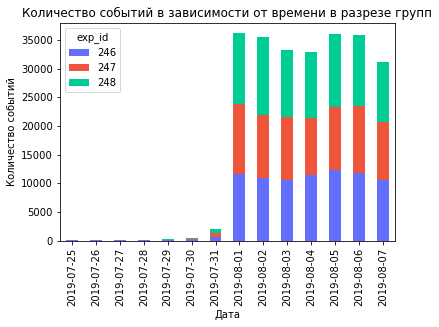

In [15]:
grouped = data.groupby(['date', 'exp_id']).size().unstack(fill_value=0)

grouped.plot(kind='bar', stacked=True, color=colors)
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

<div class="alert alert-info">По графику можно заметить, что данные не одинаково полные за весь период. Данных за первую неделю значительно меньше, чем за вторую: в каждый из первых 7 дней событий меньше 5 тысяч, в то время как в последующие дни более 30 тысяч. Таким образом, данные за первую неделю нельзя брать в анализ, иначе результаты будут скошены. Уберем данные с 25 по 31 июля.

In [16]:
target_date = pd.to_datetime('2019-08-01')
data = data[data['date'] >= target_date].reset_index(drop=True)
data

,event_name,device_id,event_timestamp,exp_id,date_time,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
240882,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
240883,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
240884,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
240885,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


<div class="alert alert-info"> Анализируемый период: с 1 по 7 августа

6. Посчитаем, сколько событий и пользователей мы потеряли, отбросив данные

In [17]:
dif_events = events - data.shape[0]
dif_users = users -  data['device_id'].nunique()
percent_event = round(dif_events/events * 100,2)
percent_user = round(dif_users/users * 100,2)
print(f'Потеряли {dif_events} событий ({percent_event}%) и {dif_users} пользователей ({percent_user}%)')

Потеряли 2826 событий (1.16%) и 17 пользователей (0.23%)


<div class="alert alert-info"> Потеряли совсем незначительный процент данных, значит действительно может отбросить события за первую неделю.

7. Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

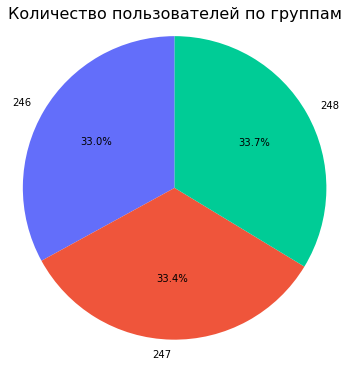

In [18]:
grouped_data = data.groupby('exp_id')['device_id'].nunique().reset_index()
grouped_data.columns = ['exp_id', 'num_users']

plt.figure(figsize=(6, 6))
plt.pie(grouped_data['num_users'], labels=grouped_data['exp_id'], autopct='%1.1f%%', startangle=90, textprops={'color': 'black'}, colors=colors)

plt.title('Количество пользователей по группам', fontsize=16)

plt.axis('equal') 
plt.show()

<div class="alert alert-info">По графику видно, что в данных есть пользователи с каждой из трех групп, причем они распределены почти равномерно (~33% в каждой группе)

<div class="alert alert-info">
<b>Выводы по 2 шагу:</b>
    
- Всего 243713 событий и 7551 пользователь
- В среднем 20 событий приходится на 1 пользователя
- Отбросили данные за 1 неделю (с 25 по 31 июля), так как в них было слишком мало событий. При этом потеряли около 1% событий и 0.2% пользователей
- Анализируемый период: с 1 по 7 августа
- Проверили, что в данных есть пользователи с каждой из трех групп и они распределены почти равномерно (~33% в каждой группе)

### Шаг 3. Изучение воронки событий

1. Посмотрим, какие события есть в логах и как часто они встречаются

In [19]:
data_events = data['event_name'].value_counts().reset_index()
data_events.columns = ['event_name', 'frequency']
data_events = data_events.sort_values(by='frequency', ascending=False)
data_events

,event_name,frequency
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


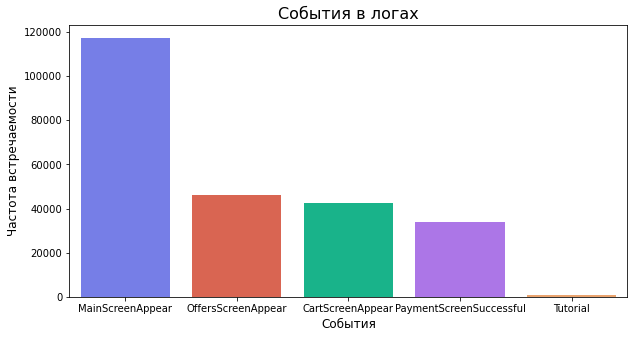

In [20]:
plt.figure(figsize=(10, 5))
sns.barplot(data=data_events, x='event_name', y='frequency', palette=colors)

plt.title('События в логах', fontsize=16)
plt.xlabel('События', fontsize=12)
plt.ylabel('Частота встречаемости', fontsize=12)

plt.show()

<div class="alert alert-info">События MainScreenAppear встречаются чаще всего (около 120 тысяч). Их количество почти в 3 раза больше чем событий OffersScreenAppear, CartScreenAppear и PaymentScreenSuccessful, который примерно одинаково (46, 42 и 34 тысячи). Количество событий Tutorial совсем незначительно - 1005.

2. Посчитаем, сколько пользователей совершали каждое из этих событий

In [21]:
users_per_event = data.groupby('event_name')['device_id'].nunique().reset_index()
users_per_event.columns = ['event_name', 'num_users']
users_per_event = users_per_event.sort_values(by='num_users', ascending=False).reset_index(drop=True)

total_users = data['device_id'].nunique()
users_per_event['user_proportion'] = round(users_per_event['num_users'] / total_users,2)

users_per_event

,event_name,num_users,user_proportion
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


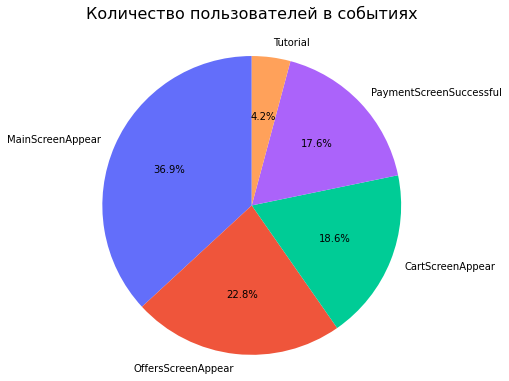

In [22]:
plt.figure(figsize=(6, 6))
plt.pie(users_per_event['num_users'], labels=users_per_event['event_name'], autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'color': 'black'})

plt.title('Количество пользователей в событиях', fontsize=16, pad=25)

plt.axis('equal') 
plt.show()

Предположим, в каком порядке происходят события

<div class="alert alert-info">Скорее всего события происходят в таком порядке:
    
<br>1) MainScreenAppear (открываем главную страницу)

2) OffersScreenAppear (выбираем товары на странице каталога)

3) CartScreenAppear (открываем корзину с выбранными товарами)

4) PaymentScreenSuccessful (оплачиваем заказ)

<br>Tutorial может происходить между любыми, указанными выше событиями, и не является обязательным для пользователей. Об этом говорит и его доля, всего 4% пользователей переходят на эту страницу. Таким образом не будем включать данное событие в воронку событий.

3. Посчитаем, какая доля пользователей проходит на следующий шаг воронки

In [23]:
users_per_event = users_per_event.iloc[:-1]
users_per_event

,event_name,num_users,user_proportion
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47


In [24]:
next_step_users = users_per_event['num_users'].shift(1)

conversion = round(users_per_event['num_users']/next_step_users*100,1)
users_per_event['conversion'] = conversion.values

users_per_event

,event_name,num_users,user_proportion,conversion
0,MainScreenAppear,7419,0.98,NaN
1,OffersScreenAppear,4593,0.61,61.9
2,CartScreenAppear,3734,0.50,81.3
3,PaymentScreenSuccessful,3539,0.47,94.8


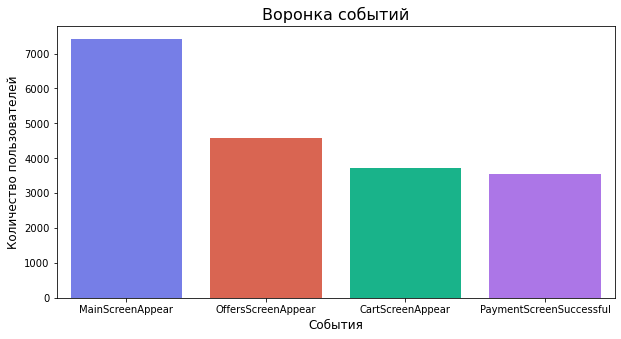

In [25]:
plt.figure(figsize=(10, 5))
sns.barplot(data=users_per_event, x='event_name', y='num_users', palette=colors)

plt.title('Воронка событий', fontsize=16)
plt.xlabel('События', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)

plt.show()

<div class="alert alert-info">На переходе от главного экрана к каталогу теряется больше всего пользователей, около 38%. При переходе от корзине к оплате теряется меньше всего - 5% пользователей, а от каталога к корзине - около 20%.

4. Посмотрим, какая доля пользователей доходит от первого события до оплаты

In [26]:
share = round(users_per_event['num_users'][3] / users_per_event['num_users'][0]*100,1)
print(f'От первого события до оплаты доходит {share}% пользователей')

От первого события до оплаты доходит 47.7% пользователей


<div class="alert alert-info">Таким образом, до оплаты доходит меньше половины всех пользователей, посетивших главную страницу

<div class="alert alert-info">
<b>Выводы по 3 шагу:</b>
    
- События MainScreenAppear встречаются чаще всего - около 120 тысяч, что в примерно в 3 раза больше, чем событий OffersScreenAppear, CartScreenAppear и PaymentScreenSuccessful. Событий Tutorial очень мало - около 1 тысячи.
- Выделили воронку событий:
    - MainScreenAppear 
    - OffersScreenAppear 
    - CartScreenAppear 
    - PaymentScreenSuccessful
События Tutorial не вошли в воронку.
- Проанализировали доли в воронке событий:
    - От события MainScreenAppear к событию OffersScreenAppear проходит 62% пользователей
    - От события OffersScreenAppear к событию CartScreenAppear — 81,2% пользователей
    - От события CartScreenAppear к событию PaymentScreenSuccessful — 94,7% пользователей
    - От первого события до оплаты доходит 47.7% пользователей
    
Таким образом, больше всего пользователей теряется при переходе с главного экрана к каталогу. Чтобы снизить этот процент, стоит разместить на главную страницу более явное предложение перейти к катологу (например, более красочную и большую кнопку). Также возможно, что главная страница недостаточно хорошо рассказывает пользователям о товарах магазина (в общих чертах) и у них не возникает желания заглянуть в каталог.  

### Шаг 4. Изучим результаты эксперимента 

1. Еще раз посмотрим сколько пользователей в каждой экспериментальной группе

In [27]:
grouped_data

,exp_id,num_users
0,246,2484
1,247,2513
2,248,2537


2. Проверим, находят ли статистические критерии разницу между выборками 246 и 247 (проведем А/А-эксперимента)

H0: Среди среднего количества пользователей групп 246 и 247 нет различий

H1: Среди среднего количества пользователей групп 246 и 247 есть различия

In [28]:
t1 = data.query('exp_id == 246')
t2 = data.query('exp_id == 247')
t3 = data.query('exp_id == 248')

In [29]:
results_AB = st.ttest_ind(t1['device_id'], t2['device_id'])
print('p-значение для сравнения групп 246 и 247:', results_AB.pvalue)

p-значение для сравнения групп 246 и 247: 2.155939166417117e-25


<div class="alert alert-info">Отвергнуть нулевую гипотезу не можем: различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости. Таким образом, мы можем быть уверены в точности дальнейшего тестирования.

3. Выберем самое популярное событие в каждой из контрольных групп.

In [30]:
t1_per_event = t1.groupby('event_name')['device_id'].nunique().reset_index()
t1_per_event.columns = ['event_name', 'num_users']
t1_per_event = t1_per_event.sort_values(by='num_users', ascending=False).reset_index(drop=True)

total_users = t1['device_id'].nunique()
t1_per_event['user_proportion'] = round(t1_per_event['num_users'] / total_users,2)

t1_per_event

,event_name,num_users,user_proportion
0,MainScreenAppear,2450,0.99
1,OffersScreenAppear,1542,0.62
2,CartScreenAppear,1266,0.51
3,PaymentScreenSuccessful,1200,0.48
4,Tutorial,278,0.11


In [31]:
t2_per_event = t2.groupby('event_name')['device_id'].nunique().reset_index()
t2_per_event.columns = ['event_name', 'num_users']
t2_per_event = t2_per_event.sort_values(by='num_users', ascending=False).reset_index(drop=True)

total_users = t2['device_id'].nunique()
t2_per_event['user_proportion'] = round(t1_per_event['num_users'] / total_users,2)

t2_per_event

,event_name,num_users,user_proportion
0,MainScreenAppear,2476,0.97
1,OffersScreenAppear,1520,0.61
2,CartScreenAppear,1238,0.50
3,PaymentScreenSuccessful,1158,0.48
4,Tutorial,283,0.11


<div class="alert alert-info"> Самым популярным событием в обеих контрольных группах является открытие главного экрана: 99% и 97% пользователей совершают это событие в 246 и 247 группах соответственно.

4. Проверим, будет ли отличие между группами 246 и 247 статистически достоверным.

H0: Среди долей пользователей групп 246 и 247 нет различий

H1: Среди долей пользователей групп 246 и 247 есть различия

In [32]:
def stat_test(g1, g2, event):
    
    t1 = g1.groupby('event_name')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False)
    t2 = g2.groupby('event_name')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False)
    
    trial = t1['device_id'].sum()
    succes = t1.query('event_name == @event')['device_id']

    trial2 = t2['device_id'].sum()
    succes2 = t2.query('event_name == @event')['device_id']
    
    shidak = 1 - (1 - 0.05)**(1/16)

    successes = np.array([succes, succes2])
    trials = np.array([trial, trial2])
    
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    difference = p1 - p2 
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < shidak:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [33]:
def test(group1, group2, event1, event2, event3, event4):
    print(f'Разница в {event1}:')
    stat_test(group1, group2, event1)
    print(f'\nРазница в {event2}:')
    stat_test(group1, group2, event2)
    print(f'\nРазница в {event3}:')
    stat_test(group1, group2, event3)
    print(f'\nРазница в {event4}:')
    stat_test(group1, group2, event4)

In [34]:
t1['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'CartScreenAppear'], dtype=object)

In [35]:
test(t1, t2, 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear')

Разница в MainScreenAppear:
p-значение:  [0.38589665]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в OffersScreenAppear:
p-значение:  [0.86810218]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в PaymentScreenSuccessful:
p-значение:  [0.47805195]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в CartScreenAppear:
p-значение:  [0.71280924]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-info">Мы посмотрели на доли пользователей каждого события. Все тесты показали, что статистически значимых различий в долях пользователей среди групп 246 и 247 нет. Следовательно разбиение на группы работает корректно.

5. Проверим различия в долях с группой с изменённым шрифтом (248) и группой 246.

In [36]:
test(t1, t3, 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear')

Разница в MainScreenAppear:
p-значение:  [0.360908]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в OffersScreenAppear:
p-значение:  [0.90236007]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в PaymentScreenSuccessful:
p-значение:  [0.73292237]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в CartScreenAppear:
p-значение:  [0.47899965]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-info">Все тесты показали, что статистически значимых различий в долях пользователей среди групп 246 и 248 нет.

6. Проверим различия в долях с группой 248 и группой 247.

In [37]:
test(t2, t3, 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear')

Разница в MainScreenAppear:
p-значение:  [0.96395635]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в OffersScreenAppear:
p-значение:  [0.96527644]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в PaymentScreenSuccessful:
p-значение:  [0.7125605]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в CartScreenAppear:
p-значение:  [0.73496329]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-info">Все тесты показали, что статистически значимых различий в долях пользователей среди групп 247 и 248 нет.

7. Проверим различия в долях с группой 248 и объединенной контрольной группой.

In [38]:
t12 = data.query('exp_id == 246 | exp_id == 247')

In [39]:
test(t12, t3, 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear')

Разница в MainScreenAppear:
p-значение:  [0.57886627]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в OffersScreenAppear:
p-значение:  [0.96325525]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в PaymentScreenSuccessful:
p-значение:  [0.98944572]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Разница в CartScreenAppear:
p-значение:  [0.54551553]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-info">Все тесты показали, что статистически значимых различий в долях пользователей объединенной контрольной группы и группы 248 нет.

<div class="alert alert-info">Таким образом, можно сделать вывод, что изменение шрифтов в приложении не повлияло на поведение пользователей.

<div class="alert alert-info">
<b>Выводы по 4 шагу:</b>
    
- A/A тест показал, что среднее значение контрольных групп 246 и 247 не различается, следовательно тест проводился корректно.
- Статистически значимых различий в долях пользователей среди групп 246 и 247 также нет.
- Самым популярным событием в обеих контрольных группах является открытие главного экрана (99% и 97%)
- Все A/A/B тесты показали, что различий в долях пользователей среди контрольных и эксперементальной группы нет. Следовательно,изменение шрифтов в приложении не повлияло на поведение пользователей.

<div class="alert alert-info">
<b>Общий вывод:</b>
    
1) Анализируемый период: с 1 по 7 августа
    
2) Воронка событий:
    <br>- MainScreenAppear (открываем главную страницу)
    <br>- OffersScreenAppear (выбираем товары на странице каталога)
    <br>- CartScreenAppear (открываем корзину с выбранными товарами)
    <br>- PaymentScreenSuccessful (оплачиваем заказ)
    
<br>Событие Tutorial не включаем в воронку событий, так как оно является не обязательным для пользователей, о чем говорит его доля (4%).    

<br>3) Воронка событий (доля пользователей):
    <br>- От события MainScreenAppear к событию OffersScreenAppear проходит 62% пользователей
    <br>- От события OffersScreenAppear к событию CartScreenAppear — 81,2% пользователей 
    <br>- От события CartScreenAppear к событию PaymentScreenSuccessful — 94,7% пользователей  
<br>Больше всего пользователей теряется на шаге от события MainScreenAppear к событию OffersScreenAppear — 38% пользователей, а от первого события до оплаты доходит 47,7% пользователей.
    
<br>4) А/А/В-тест:
<br>Доли пользователей в контрольных группах равны, разбиение на группы работает корректно. Нет статистически значимого различия между контрольными группами и экспериментальной группой с изменённым шрифтом. Таким образом, изменение шрифта не влияет на поведение пользователей.    

<br>Так как данные доступны только за 1 неделю, они могут быть не совсем репрезентативны. Стоит собрать данные хотя бы еще за 1 неделю и провести повторный анализ. Однако ожидать, что ситуация сильно изменится и появятся статистически значимые различия между группами, не стоит, так как уже по полученным p_value можно сказать, что различия совсем незначительны.